# Thêm thư viện cần thiết


In [3]:
import pandas as pd
import warnings
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.utils import column_or_1d
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

warnings.filterwarnings('ignore')


# Nạp dữ liệu


In [5]:
df = pd.read_csv("../Dataset/BTC-USD.csv", parse_dates=True,
                 index_col=0).drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'])

df_index = df.index
df.head()

,Close
Date,
2021-06-05,35551.957031
2021-06-06,35862.378906
2021-06-07,33560.707031
2021-06-08,33472.632812
2021-06-09,37345.121094


# Vẽ đồ thị

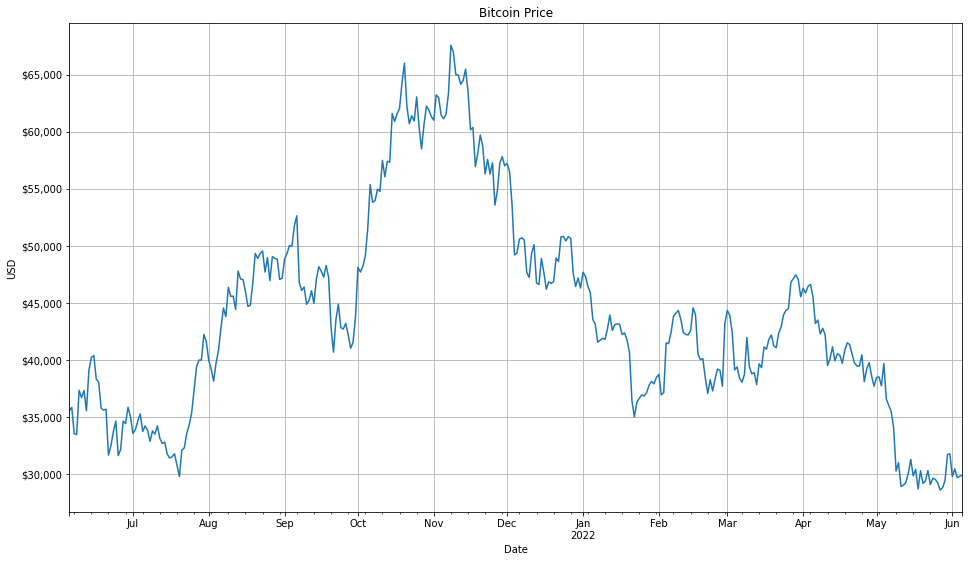

In [33]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Bitcoin Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['Close'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)


# Kiểm tra tính dừng của chuỗi

In [8]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")


In [34]:
adf_test(df['Close'], 'Bitcoin Price')


Augmented Dickey-Fuller Test: Bitcoin Price
ADF test statistic         -1.390025
p-value                     0.587049
Number of lags used         0.000000
Number of observations    365.000000
critical value (1%)        -3.448394
critical value (5%)        -2.869491
critical value (10%)       -2.571006
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


##### Nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng


# Lấy sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng


In [10]:
df['diff1'] = df['Close'].diff()
df.head()


,Close,diff1
Date,,
2021-06-05,35551.957031,NaN
2021-06-06,35862.378906,310.421875
2021-06-07,33560.707031,-2301.671875
2021-06-08,33472.632812,-88.074219
2021-06-09,37345.121094,3872.488281


<AxesSubplot:xlabel='Date'>

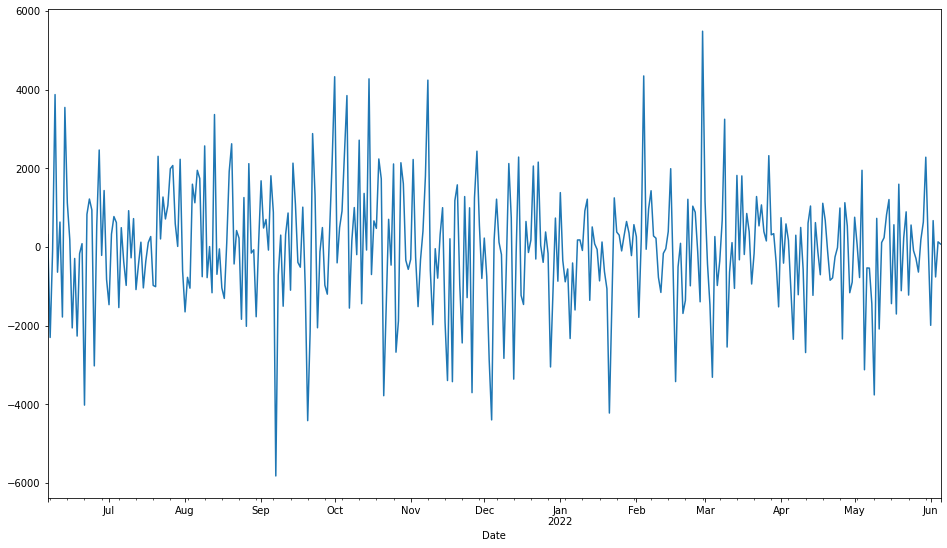

In [13]:
df['diff1'].dropna().plot(figsize=(16, 9))


# Kiểm định tính dừng của chuỗi tại sai phân bậc 1


In [14]:
adf_test(df['diff1'], 'Bitcoin Price at First Difference')


Augmented Dickey-Fuller Test: Bitcoin Price at First Difference
ADF test statistic       -1.487517e+01
p-value                   1.640715e-27
Number of lags used       1.000000e+00
Number of observations    3.630000e+02
critical value (1%)      -3.448494e+00
critical value (5%)      -2.869535e+00
critical value (10%)     -2.571029e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


##### Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1


# Thực hiện xây dựng mô hình ARIMA

## Cần chuẩn hóa dữ liệu để thuận tiện cho việc xây dựng mô hình

In [20]:
df_scaled = df.copy().drop(columns=['diff1'])

scaler = StandardScaler()

df_scaled['Close'] = scaler.fit_transform(df_scaled['Close'].values.reshape(-1, 1))
df_scaled.head()

,Close
Date,
2021-06-05,-0.903048
2021-06-06,-0.868956
2021-06-07,-1.121731
2021-06-08,-1.131403
2021-06-09,-0.706119


## Chia dữ liệu thành tập train và tập test

In [21]:
train_data, test_data = df_scaled[df_scaled.index < '2022-01-01'], df_scaled[df_scaled.index >= '2022-01-01']
index_test = df_scaled.index[df_scaled.index >= '2022-01-01']
print(train_data.shape)
print(test_data.shape)

(210, 1)
(156, 1)


In [23]:
train_data.tail()

,Close
Date,
2021-12-27,0.753998
2021-12-28,0.418869
2021-12-29,0.293217
2021-12-30,0.373762
2021-12-31,0.278032


In [24]:
test_data.head()

,Close
Date,
2022-01-01,0.429627
2022-01-02,0.392113
2022-01-03,0.294689
2022-01-04,0.233129
2022-01-05,-0.022599


## Tìm các hệ số p, q và d phù hợp cho mô hình ARIMA

In [25]:
warnings.filterwarnings('ignore')


def arima_model(ts_data):
    fit_model = auto_arima(ts_data, test='adf', seasonal=False, trace=True)
    print(fit_model.summary())
    return fit_model


#### Dựa vào chỉ số AIC
- Chỉ số AIC càng thấp thì mô hình càng phù hợp

In [26]:
fitted = arima_model(train_data)
fitted.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-113.056, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-107.763, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-105.808, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-105.827, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-109.569, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-105.718, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-106.628, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-111.551, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-111.567, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-104.308, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-104.083, Time=0.67 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-105.291, Time=0.18 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-109.303, Time=0.53 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-114.788, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  210
Model:               SARIMAX(2, 1, 2)   Log Likelihood                  62.394
Date:                Tue, 07 Jun 2022   AIC                           -114.788
Time:                        15:02:10   BIC                            -98.076
Sample:                             0   HQIC                          -108.031
                                - 210                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3899      0.076      5.130      0.000       0.241       0.539
ar.L2         -0.9030      0.074    -12.242      0.000      -1.048      -0.758
ma.L1         -0.4070      0.115     -3.554      0.000      -0.631      -0.183
ma.L2          0.7968      0.097      8.220      0.000       0.607       0.987
sigma2         0.0322      0.003     11.387      0.000       0.027       0.038
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 6.45
Prob(Q):                              0.76   Prob(JB):                         0.04
Heteroskedasticity (H):               1.34   Skew:                            -0.28
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Dự đoán trên tập test


In [27]:
pred = fitted.predict(len(test_data))
pred


array([0.23986684, 0.22514697, 0.25387277, 0.27836483, 0.26197331,
       0.23346546, 0.23715303, 0.26433432, 0.27160165, 0.24988936,
       0.2348616 , 0.24860958, 0.26754019, 0.26250588, 0.24344812,
       0.24056411, 0.25664952, 0.26552521, 0.25445993, 0.2421308 ,
       0.24731628, 0.26047162, 0.2609179 , 0.24921217, 0.24424537,
       0.25287962, 0.2607311 , 0.25599518, 0.24705859, 0.24785113,
       0.25623018, 0.25878128, 0.25220932, 0.24734334, 0.25138091,
       0.25734922, 0.25603005, 0.25012615, 0.24901561, 0.25391407,
       0.25682671, 0.25353881, 0.24962671, 0.25107057, 0.25516626,
       0.25545921, 0.25187488, 0.25021289, 0.25280169, 0.25531184,
       0.25395271, 0.25115607, 0.25129306, 0.25387194, 0.25475368,
       0.25276862, 0.25119846, 0.25237887, 0.25425699, 0.25392328,
       0.25209716, 0.25168655, 0.25317551, 0.25412682, 0.25315312,
       0.25191445, 0.25231079, 0.25358389, 0.25372232, 0.25262665,
       0.25207446, 0.2528486 , 0.25364907, 0.25326208, 0.25238

# Vẽ đồ thị cho tập test và kết quả dự đoán

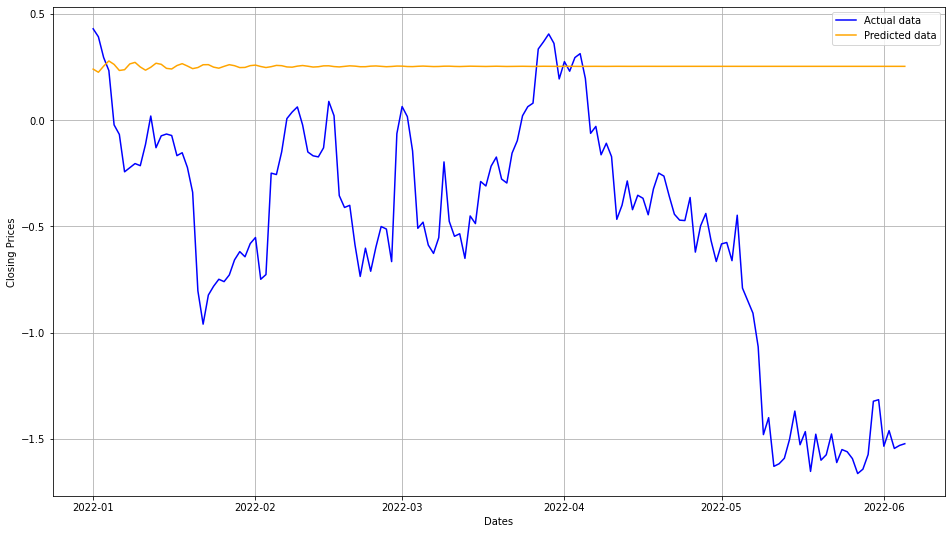

In [30]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_data, 'blue', label='Actual data')
plt.plot(pred_series, 'orange', label='Predicted data')
plt.legend()


# Đưa dữ liệu về miền giá trị ban đầu


In [31]:
actual = column_or_1d(test_data)
pred = column_or_1d(pred)

inv_actual = scaler.inverse_transform(actual.reshape(-1, 1))
inv_pred = scaler.inverse_transform(pred.reshape(-1, 1))


# Đánh giá mô hình qua các chỉ số MAE, MAPE, MSE, RMSE

In [32]:
mae = mean_absolute_error(inv_actual, inv_pred)
mape = mean_absolute_percentage_error(inv_actual, inv_pred)
mse = mean_squared_error(inv_actual, inv_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 7135.87
MAPE: 20.52%
MSE: 75458671.81
RMSE: 8686.70
